# Random Forest Classifier and Regression

## 1. Background

Random forests or random decision forests are an ensemble learning method for classification and regression that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.
Random decision forests correct for decision trees' habit of overfitting to their training set.

Each tree in the ensemble is built from a sample drawn with replacement (i.e. bootstrapping) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features. As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.

Note: The scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

A more detailed discussion can be found in this [video](https://www.youtube.com/watch?v=3kYujfDgmNk&index=12&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6) from Nando de Freitas' ML course, and from the wikipedia [article](https://en.wikipedia.org/wiki/Random_forest), and the scikit [article](http://scikit-learn.org/stable/modules/ensemble.html).

## 2. Classification Example

In this example we use a decision tree to help us classify the iris dataset.

The iris dataset consists of 150 samples: 50 from each of three species of Iris flowers, and four features for each sample (Sepal Length, Sepal Width, Petal Length and Petal Width). Thus, the dataset consists of three classes, four features, and 150 samples (50 for each class).

Here, we plot the decision surfaces of forests of randomized trees trained on pairs of features of the iris dataset.
The plot compares the decision surfaces learned by a decision tree classifier (first column), by a random forest classifier (second column), by an extra- trees classifier (third column) and by an AdaBoost classifier (fourth column).

In the first row, the classifiers are built using the sepal width and the sepal length features only, on the second row using the petal length and sepal length only, and on the third row using the petal width and the petal length only.

Insipred by this [example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_iris.html).

DecisionTree with features [0, 1] has a score of 0.813333333333
RandomForest with 30 estimators with features [0, 1] has a score of 0.926666666667
ExtraTrees with 30 estimators with features [0, 1] has a score of 0.926666666667
AdaBoost with 30 estimators with features [0, 1] has a score of 0.84
DecisionTree with features [0, 2] has a score of 0.953333333333
RandomForest with 30 estimators with features [0, 2] has a score of 0.993333333333
ExtraTrees with 30 estimators with features [0, 2] has a score of 0.993333333333
AdaBoost with 30 estimators with features [0, 2] has a score of 0.993333333333
DecisionTree with features [2, 3] has a score of 0.973333333333
RandomForest with 30 estimators with features [2, 3] has a score of 0.993333333333
ExtraTrees with 30 estimators with features [2, 3] has a score of 0.993333333333
AdaBoost with 30 estimators with features [2, 3] has a score of 0.993333333333


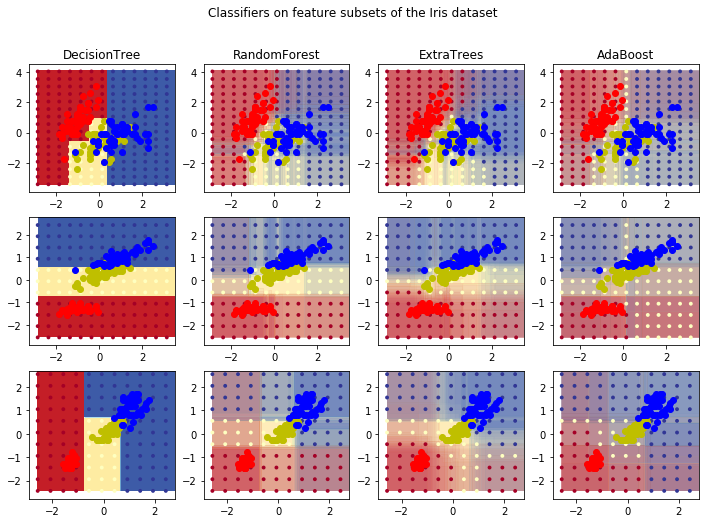

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import clone
from sklearn.datasets import load_iris
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)
from sklearn.externals.six.moves import xrange
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
n_estimators = 30
plot_colors = "ryb"
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration

# Load data
iris = load_iris()

plot_idx = 1

models = [DecisionTreeClassifier(max_depth=3),
          RandomForestClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                             n_estimators=n_estimators)]

for pair in ([0, 1], [0, 2], [2, 3]):
    for model in models:
        # We only take the two corresponding features
        X = iris.data[:, pair]
        y = iris.target
        plt.figure(1, figsize=(12, 8))
        
        # Shuffle
        idx = np.arange(X.shape[0])
        np.random.seed(RANDOM_SEED)
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Standardize
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        X = (X - mean) / std

        # Train
        clf = clone(model)
        clf = model.fit(X, y)

        scores = clf.score(X, y)
        # Create a title for each column and the console by using str() and
        # slicing away useless parts of the string
        model_title = str(type(model)).split(".")[-1][:-2][:-len("Classifier")]
        model_details = model_title
        if hasattr(model, "estimators_"):
            model_details += " with {} estimators".format(len(model.estimators_))
        print( model_details + " with features", pair, "has a score of", scores )

        plt.subplot(3, 4, plot_idx)
        if plot_idx <= len(models):
            # Add a title at the top of each column
            plt.title(model_title)

        # Now plot the decision boundary using a fine mesh as input to a
        # filled contour plot
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                             np.arange(y_min, y_max, plot_step))

        # Plot either a single DecisionTreeClassifier or alpha blend the
        # decision surfaces of the ensemble of classifiers
        if isinstance(model, DecisionTreeClassifier):
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            cs = plt.contourf(xx, yy, Z, cmap=cmap)
        else:
            # Choose alpha blend level with respect to the number of estimators
            # that are in use (noting that AdaBoost can use fewer estimators
            # than its maximum if it achieves a good enough fit early on)
            estimator_alpha = 1.0 / len(model.estimators_)
            for tree in model.estimators_:
                Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

        # Build a coarser grid to plot a set of ensemble classifications
        # to show how these are different to what we see in the decision
        # surfaces. These points are regularly space and do not have a black outline
        xx_coarser, yy_coarser = np.meshgrid(np.arange(x_min, x_max, plot_step_coarser),
                                             np.arange(y_min, y_max, plot_step_coarser))
        Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(), yy_coarser.ravel()]).reshape(xx_coarser.shape)
        cs_points = plt.scatter(xx_coarser, yy_coarser, s=15, c=Z_points_coarser, cmap=cmap, edgecolors="none")

        # Plot the training points, these are clustered together and have a
        # black outline
        for i, c in zip(xrange(n_classes), plot_colors):
            idx = np.where(y == i)
            plt.scatter(X[idx, 0], X[idx, 1], c=c, label=iris.target_names[i],
                        cmap=cmap)

        plot_idx += 1  # move on to the next plot in sequence

plt.suptitle("Classifiers on feature subsets of the Iris dataset")
plt.axis("tight")

plt.show()

## 3. Regression Example

As discussed earlier, Random Forests are also capable of performing regression to model continuos variables.
In this example we compare a decision tree model to a random forest regression model to predict data created from cosine function.

Inspired by this [example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html#sphx-glr-auto-examples-ensemble-plot-random-forest-regression-multioutput-py).

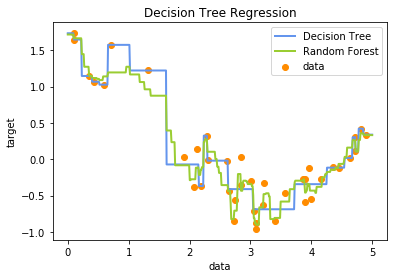

In [2]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

max_depth = 30
# Create a random dataset
np.random.seed(0)
X = np.sort(5 * np.random.rand(40, 1)) # create 40 random points and scale by 5 and sort them.
X_test = np.linspace(0, 5, 500)[:, np.newaxis] # split [0,5] into 500 intervals then put into single elements array
y = np.cos(X).ravel()+np.random.rand(40) # Create a target by taking the sine of X and adding some noise.

# Fit regression model
regr_dt = DecisionTreeRegressor(max_depth=5)
regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)
regr_dt.fit(X, y)
regr_rf.fit(X, y)

# Predict
y_1 = regr_dt.predict(X_test)
y_2 = regr_rf.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="Decision Tree", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="Random Forest", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()